Домашнее задание

  Обучить генератор создавать точки, которые будут лежать на графике функции
  - y=sin(x)x − x10
  
  При выполнении данного задания структура GAN остается той же, но Вам нужно:

    - Сгенерировать настоящие данные
    - Изменить архитектуру дискриминатора и генератора
    - Построить графики


In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def my_func(x):
    return (np.sin(x)*x) - (x*10)

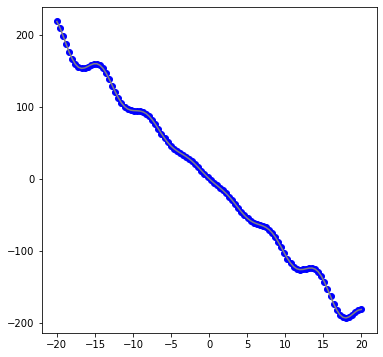

In [4]:
# визуализация графика функции

fig, ax = plt.subplots(figsize=(6, 6))
x = np.linspace(-20, 20, 100)
ax.scatter(x, y = my_func(x), color='blue')
plt.plot(x, my_func(x), color='gray')
plt.show()

In [5]:
#генератор точек для датасета
def point_gen(ax, n):
    points = pd.DataFrame([(x, my_func(x)) for x in np.random.uniform(-ax, ax, size=(1, n))[0]], columns=['x', 'y'])
    return points

In [6]:
df_train = point_gen(10, 300000)
df_train

,x,y
0,5.484954,-58.777439
1,4.108092,-44.461474
2,-7.681817,84.386426
3,9.434823,-94.443008
4,-4.244421,38.656121
...,...,...
299995,-3.463921,33.541922
299996,-2.619752,27.503406
299997,3.904802,-41.747198
299998,-7.313856,79.411238


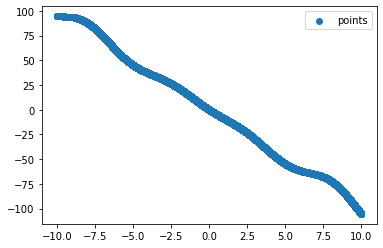

In [7]:
x,y = df_train.values.T
plt.scatter(x,y,label='points')
plt.legend()
plt.show()

In [8]:
#проведем нормализацию
scaler = MinMaxScaler()
data_train = scaler.fit_transform(df_train)  
data_train = torch.FloatTensor(data_train).float()
data_train

tensor([[0.7743, 0.2333],
        [0.7054, 0.3049],
        [0.1159, 0.9491],
        ...,
        [0.6952, 0.3185],
        [0.1343, 0.9243],
        [0.0825, 0.9814]])

In [9]:
class DatasetClass(torch.utils.data.Dataset):
   
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        point = self._data[idx] 
       
        return point

In [10]:
train_dataset = DatasetClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=256,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [12]:
discriminator = Discriminator()

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [14]:
generator = Generator()

In [15]:
lr = 0.001
num_epochs = 50
batch_size = 256
loss_function = nn.BCELoss()

In [16]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [27]:
%%time

for epoch in range(num_epochs):
    for n, real_samples in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6674926280975342
Epoch: 0 Loss G.: 0.6553568243980408
Epoch: 10 Loss D.: 0.6447811126708984
Epoch: 10 Loss G.: 0.7806423306465149
Epoch: 20 Loss D.: 0.6111704707145691
Epoch: 20 Loss G.: 0.9001796245574951
Epoch: 30 Loss D.: 0.6582387685775757
Epoch: 30 Loss G.: 0.8689886331558228
Epoch: 40 Loss D.: 0.6547841429710388
Epoch: 40 Loss G.: 0.83376145362854
Wall time: 16min 14s


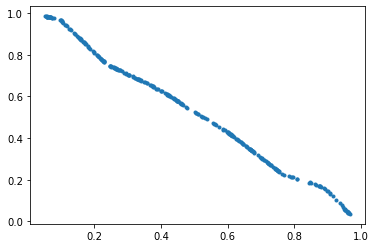

In [28]:
latent_space_samples = torch.randn(300, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")